In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR100
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split,ConcatDataset
from torchsummary import summary

import ResNet
import ResNet1
import data
import CNN
import evaluate
import train

Files already downloaded and verified


In [4]:
nets, train_loss_his, test_loss_his = train.train_smallNet(10000,1000,5)

iter:    100, train loss: 4.693605713844299, test_loss: 184.72541332244873
accuracy: 1.8800000000000001%
iter:    200, train loss: 4.590692648887634, test_loss: 182.6784429550171
accuracy: 2.69%
iter:    300, train loss: 4.538765845298767, test_loss: 180.56539297103882
accuracy: 2.67%
iter:    400, train loss: 4.4893702793121335, test_loss: 178.44577646255493
accuracy: 3.6700000000000004%
iter:    500, train loss: 4.441256403923035, test_loss: 176.0844464302063
accuracy: 4.5%
iter:    600, train loss: 4.3743652248382565, test_loss: 174.16680431365967
accuracy: 4.89%
iter:    700, train loss: 4.336166162490844, test_loss: 172.2370376586914
accuracy: 5.28%


KeyboardInterrupt: ignored

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
net1 = ResNet1.ResNet(ResNet.BasicBlock, [2, 2, 2, 2],100).to(device)

In [31]:
net2 = ResNet.resnet34(100).to(device)

In [28]:

summary(net1, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]             216
       BatchNorm2d-2            [-1, 8, 32, 32]              16
              ReLU-3            [-1, 8, 32, 32]               0
            Conv2d-4            [-1, 8, 32, 32]             576
       BatchNorm2d-5            [-1, 8, 32, 32]              16
              ReLU-6            [-1, 8, 32, 32]               0
            Conv2d-7            [-1, 8, 32, 32]             576
       BatchNorm2d-8            [-1, 8, 32, 32]              16
        BasicBlock-9            [-1, 8, 32, 32]               0
           Conv2d-10            [-1, 8, 16, 16]             576
      BatchNorm2d-11            [-1, 8, 16, 16]              16
             ReLU-12            [-1, 8, 16, 16]               0
           Conv2d-13            [-1, 8, 16, 16]             576
      BatchNorm2d-14            [-1, 8,

In [29]:
summary(net2, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,864
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
        BasicBlock-9           [-1, 64, 32, 32]               0
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,864
      BatchNorm2d-14           [-1, 64,

In [16]:
trainDataLoader, testDataLoader =  data.loadData_minClass1(100,1)

In [17]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)  


In [7]:
def evaluate(model,dataloader):
  acc = 0.0
  rights = 0
  wrongs = 0
  for i, test_examples in enumerate(dataloader, 0):
    #predicting using the nets
    inputs, labels = test_examples
    predicted_outputs = model(inputs.to(device))
    #Selecting the label which has the largest outputs
    outputs = torch.argmax(predicted_outputs, 1)

    #Counting successfully and unsuccessfully predicted cases
    for j, n in enumerate(outputs):
      if n == labels[j]:
        rights += 1
      else:
        wrongs += 1
  #calculate accuracy with the cases we recorded
  acc = rights/(rights+wrongs)
  #return the accuracy
  return acc


In [24]:
def train(model,train,test,loss_fn,optimizer,watch_iter):
    total_iter = 0
    loss = 0.0

    while total_iter < 1000:
        for batch in train:
            total_iter += 1
            train_inputs, train_labels = batch
            train_outputs = model(train_inputs.to(device))
            l = loss_fn(train_outputs, train_labels.to(device))
            loss += l.item()
            optimizer.zero_grad()
            l.backward()
            optimizer.step()

            if total_iter % watch_iter == 0:
                train_loss = loss / watch_iter
                train_loss_his.append(train_loss)
                loss = 0.0
                for batch in test:
                    test_inputs, test_labels = batch
                    test_outputs = model(test_inputs.to(device))
                    l = loss_fn(test_outputs, test_labels.to(device))
                    loss += l.item()
                    #optimizer.zero_grad()
                    #l.backward()
                    #optimizer.step()
                test_loss_his.append(loss)
                txt = f'iter: {total_iter: 6d}, train loss: {train_loss}, test_loss: {loss}'
                print(txt)
                print('train accuracy: ' + str(evaluate(model,train)*100) + '%')
                print('test accuracy: ' + str(evaluate(model,test)*100) + '%')
                loss = 0.0
    return

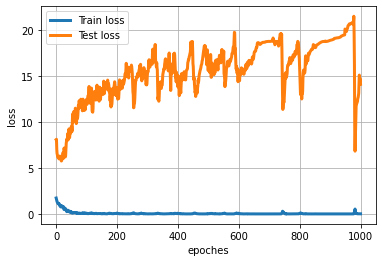

In [19]:
plt.plot(range(len(train_loss_his)),train_loss_his,'-',linewidth=3,label='Train loss')
plt.plot(range(len(train_loss_his)),test_loss_his,'-',linewidth=3,label='Test loss')
plt.xlabel('epoches')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

In [22]:
torch.argmin(torch.tensor(train_loss_his))

tensor(936)

In [ ]:
class_2 = 	[['beaver', 'dolphin', 'otter', 'seal', 'whale'],
	['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout'],
	['orchid', 'poppy', 'rose', 'sunflower', 'tulip'],
  ['bottle', 'bowl', 'can', 'cup', 'plate'],
	['apple', 'mushroom', 'orange', 'pear', 'sweet_pepper'],
	['clock', 'keyboard', 'lamp', 'telephone', 'television'],
  ['bed', 'chair', 'couch', 'table', 'wardrobe'],
	['bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach'],
	['bear', 'leopard', 'lion', 'tiger', 'wolf'],
  ['bridge', 'castle', 'house', 'road', 'skyscraper'],
	['cloud', 'forest', 'mountain', 'plain', 'sea'],
	['camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo'],
	['fox', 'porcupine', 'possum', 'raccoon', 'skunk'],
	['crab', 'lobster', 'snail', 'spider', 'worm'],
	['baby', 'boy', 'girl', 'man', 'woman'],
	['crocodile', 'dinosaur', 'lizard', 'snake', 'turtle'],
	['hamster', 'mouse', 'rabbit', 'shrew', 'squirrel'],
	['maple_tree', 'oak_tree', 'palm_tree', 'pine_tree', 'willow_tree'],
	['bicycle', 'bus', 'motorcycle', 'pickup_truck', 'train'],
	['lawn_mower', 'rocket', 'streetcar', 'tank', 'tractor']]

In [ ]:
for i, test_examples in enumerate(trainDataLoader, 0):
    inputs, labels = test_examples
    for j in range(len(labels)):
      if labels[j].item() == 2:
        plt.imshow(inputs[j].reshape(32,32,3))
        plt.title(labels[j])
        break
    if i == 2:
      break

In [ ]:
for i, test_examples in enumerate(testDataLoader, 0):
    inputs, labels = test_examples
    for j in range(len(labels)):
      if labels[j].item() == 2:
        plt.imshow(inputs[j].reshape(32,32,3))
        plt.title(labels[j])
        break
    break

In [ ]:
# Normalize training set together with augmentation
transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
        ])

# Normalize test set same as training set without augmentation
transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
        ])

    
# Load data
train_data = CIFAR100(download=True,root="./Cifar100",transform=transform_train)
test_data = CIFAR100(root="./Cifar100",train=False,transform=transform_test)

In [ ]:
train_data.classes

In [ ]:
weight_mix = [1.0/(numbers) for i in range(numbers)]
L_T_experts = []
L_T_leaner = 0
L_experts_his = []
L_leaner_his = []
p_learner = 0
lr = 0.5
for i in range(numbers):
  p = experts_spam[i].predict(x_spam_test[0].reshape(-1,56))
  if i == 4:
    p = p.argmax()
  else:
    p = 1 if p>0.5 else 0
  p_learner = weight_mix[i]*p
  Loss = (y_mix_test[0]-p)**2
  L_T_experts.append(Loss)
L_T_leaner = (y_mix_test[0]-p_learner)**2
#the history of weights needs to be recorded
weight_history_mix = []
for i in range(6):
  weight_history_mix.append([weight_mix[i]])
  L_experts_his.append([L_T_experts[i]])
L_leaner_his.append(L_T_leaner)

In [3]:
alpha = 0.2
for n in range(len(x_mix_test)):
  pl = 0
  for i in range(6):
    if len(x_mix_test[n]) == 56: 
      p = predict(experts_spam[i],np.array(x_mix_test[n]),56)
    else:
      p = predict(experts_cloud[i],np.array(x_mix_test[n]),10)
    L_T_experts[i] += (y_mix_test[n]-p)**2
    pl += p*weight_mix[i]
  updated = weight_update(weight_mix,lr,L_T_experts,alpha)
  weight_mix = updated
  for i in range(6):
    weight_history_mix[i].append(weight_mix[i])
    L_experts_his[i].append(L_T_experts[i])
  L_T_leaner += (y_mix_test[n]-pl)**2
  L_leaner_his.append(L_T_leaner)

NameError: ignored